In [2]:
%load_ext rpy2.ipython

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from pyteomics import mztab
import os

In [4]:
%%R
data_folder = '../../datasets/LFQ-DDA/PXD014415'
setwd(data_folder)

In [10]:
import gzip
file_name = './MBR/out.mzTab.gz'
f_name = file_name.replace(".gz", "")
g_file = gzip.GzipFile(file_name)
open(f_name, "wb+").write(g_file.read())
g_file.close()

In [4]:
import gzip
file_name = './MBR/out_msstats.csv.gz'
f_name = file_name.replace(".gz", "")
g_file = gzip.GzipFile(file_name)
open(f_name, "wb+").write(g_file.read())
g_file.close()

In [5]:
import gzip
file_name = './NoMBR/out_msstats.csv.gz'
f_name = file_name.replace(".gz", "")
g_file = gzip.GzipFile(file_name)
open(f_name, "wb+").write(g_file.read())
g_file.close()

In [6]:
import gzip
file_name = './NoMBR/out.mzTab.gz'
f_name = file_name.replace(".gz", "")
g_file = gzip.GzipFile(file_name)
open(f_name, "wb+").write(g_file.read())
g_file.close()

### MBR

In [7]:
quantms = pd.read_csv("./MBR/out_msstats.csv", sep=',', header=0)
quantms = quantms[-(quantms['ProteinName'].str.contains("DECOY_"))]
print(len(set(quantms['ProteinName'])))
quantms.head()

5564


,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity,Reference
0,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,Control,1,1,70152980.0,a11849_human_90min_hrMS2.mzML
1,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,Control,1,10,68018300.0,a11858_human_90min_hrMS2.mzML
2,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,Control,1,11,71465180.0,a11859_human_90min_hrMS2.mzML
3,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,Control,1,12,68788720.0,a11860_human_90min_hrMS2.mzML
4,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,Control,1,13,76549950.0,a11861_human_90min_hrMS2.mzML


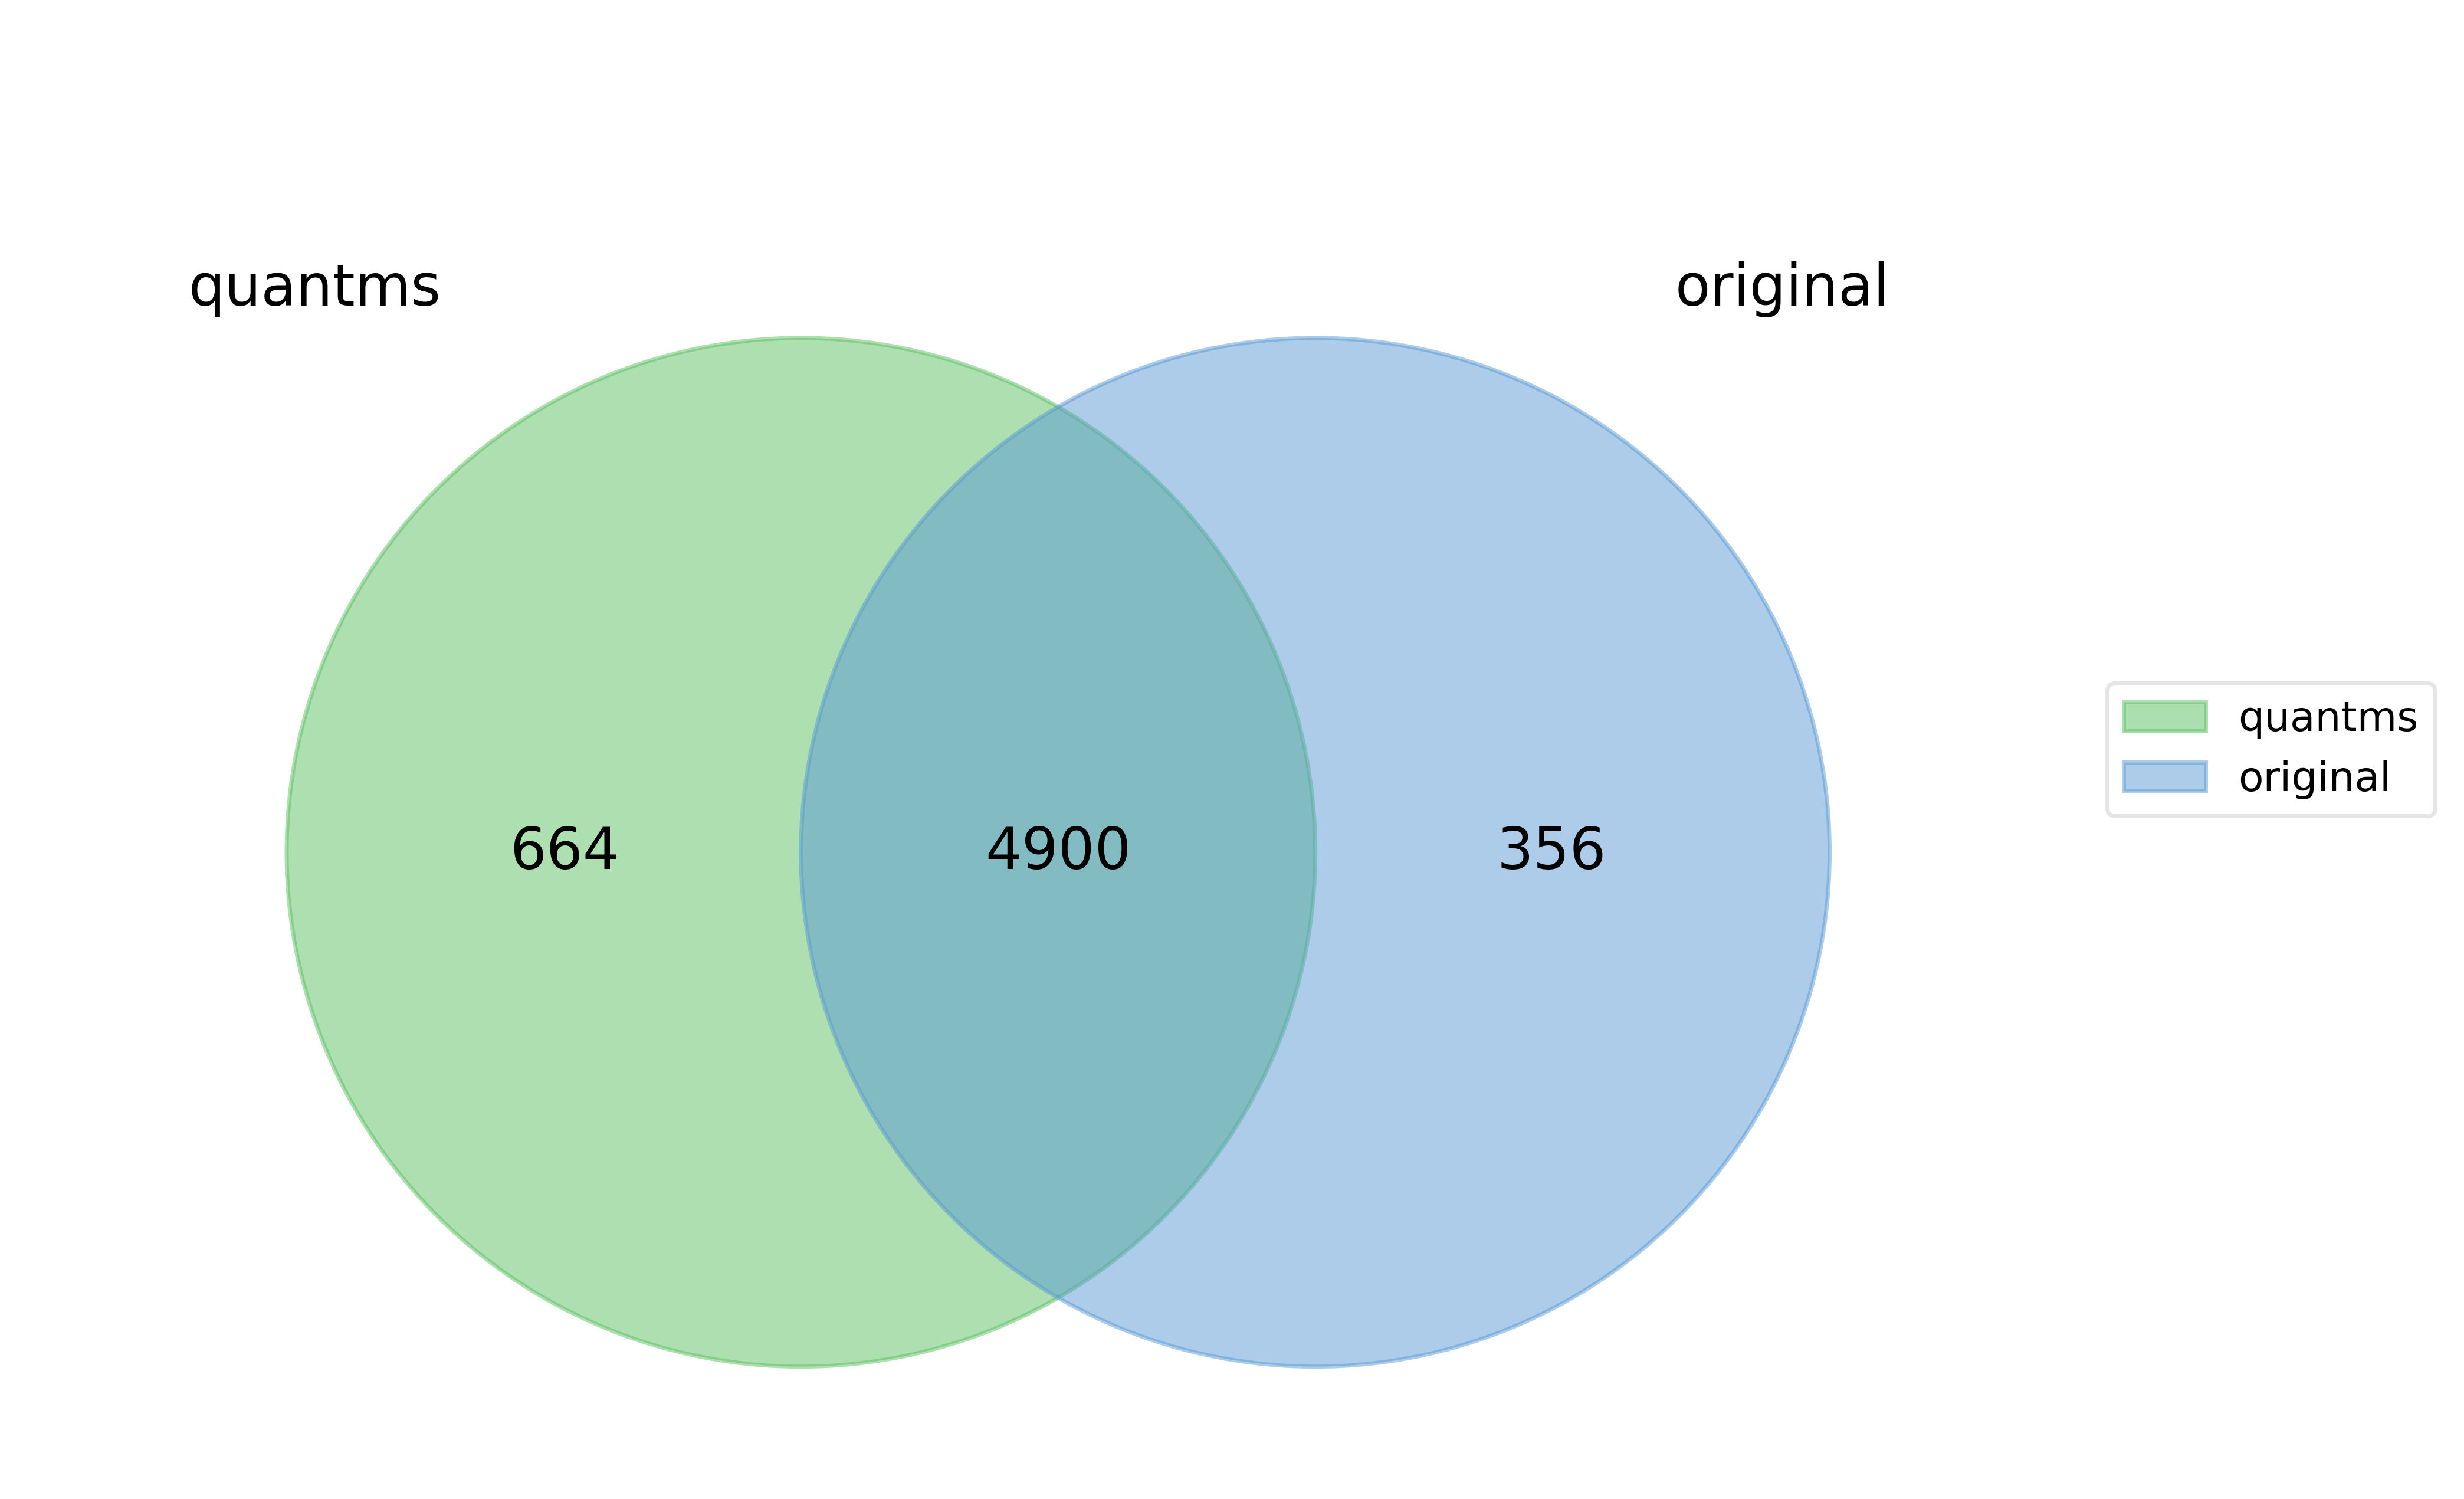

In [8]:
from pyvenn import venn
original = pd.read_excel("mmc2.xlsx", sheet_name="1", header=0)
labels = venn.get_labels([set(quantms['ProteinName']), set(original['Protein'])], fill=['number'])
fig, ax = venn.venn2(labels, names=['quantms', 'original'], dpi=500)
plt.show()                                                                           

In [17]:
data_mztab = mztab.MzTab("./MBR/out.mzTab")
quantms_pep = data_mztab.spectrum_match_table
meta_data = data_mztab.metadata

quantms_pep = quantms_pep[quantms_pep['opt_global_cv_MS:1002217_decoy_peptide'] != 1]
quantms_pep['stand_spectra_ref'] = quantms_pep.apply(
    lambda x: os.path.basename(meta_data[x.spectra_ref.split(':')[0] + '-location']), axis=1)

unique_pep = quantms_pep[quantms_pep['unique'] == 1]
MBR_unique_pep_human = unique_pep[-unique_pep['accession'].str.contains("YEAST")]
print(len(set(MBR_unique_pep_human['sequence'])))

MBR_unique_pep_yeast = unique_pep[-unique_pep['accession'].str.contains("HUMAN")]
print(len(set(MBR_unique_pep_yeast['sequence'])))

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


44113
4261


In [21]:
MBR_unique_pep_human.to_csv("./MBR/MBR_unique_pep_human.csv", sep=",", index=False)
MBR_unique_pep_yeast.to_csv("./MBR/MBR_unique_pep_yeast.csv", sep=",", index=False)

In [58]:
import re
pattern = re.compile(r"\(.*?\)")
quantms['sequence'] = quantms.apply(lambda x: pattern.sub('', x['PeptideSequence']).replace(".", ""), axis=1)

H = quantms[-quantms['Reference'].str.contains("yaeast")]
hy = []
hh = []
for reference, group in H.groupby("Reference"):
    hy.append(len(set(group[-group['ProteinName'].str.contains("HUMAN")]['sequence']).intersection(set(MBR_unique_pep_yeast[MBR_unique_pep_yeast['stand_spectra_ref'] == reference]['sequence']))))
    hh.append(len(set(group[-group['ProteinName'].str.contains("YEAST")]['sequence']).intersection(set(MBR_unique_pep_human[MBR_unique_pep_human['stand_spectra_ref'] == reference]['sequence']))))

print(hy)
print(str((max(hy) + min(hy)) / 2) + "+-" + str((max(hy) - min(hy)) / 2))

print(hh)
print(str((max(hh) + min(hh)) / 2) + "+-" + str((max(hh) - min(hh)) / 2))


Y = quantms[quantms['Reference'].str.contains("yaeast")]
YH = []
YY = []
for reference, group in Y.groupby("Reference"):
    YY.append(len(set(group[-group['ProteinName'].str.contains("HUMAN")]['sequence']).intersection(set(MBR_unique_pep_yeast[MBR_unique_pep_yeast['stand_spectra_ref'] == reference]['sequence']))))
    YH.append(len(set(group[-group['ProteinName'].str.contains("YEAST")]['sequence']).intersection(set(MBR_unique_pep_human[MBR_unique_pep_human['stand_spectra_ref'] == reference]['sequence']))))

print(YH)
print(str((max(YH) + min(YH)) / 2) + "+-" + str((max(YH) - min(YH)) / 2))

print(YY)
print(str((max(YY) + min(YY)) / 2) + "+-" + str((max(YY) - min(YY)) / 2))

[313, 325, 332, 324, 345, 334, 345, 348, 329, 324, 352, 341, 337, 348, 344, 339, 352, 346, 339, 357]
335.0+-22.0
[28252, 28535, 28000, 27815, 27678, 27747, 27851, 27768, 27629, 27588, 27847, 27779, 27753, 27672, 27891, 27346, 27621, 27509, 27442, 27471]
27940.5+-594.5
[2341, 2360, 2391, 2397, 2299, 2329, 2367, 2417, 2413, 2332, 2294, 2378, 2372, 2350, 2239, 2302, 2302, 2297, 2264, 2290]
2328.0+-89.0
[27709, 27797, 27686, 27785, 27620, 27594, 27647, 27682, 27743, 27830, 27601, 27763, 27759, 27693, 27128, 27484, 27499, 27382, 27402, 27405]
27479.0+-351.0


### No MBR

In [59]:
quantms_NoMBR = pd.read_csv("./NoMBR/out_msstats.csv", sep=',', header=0)
quantms_NoMBR = quantms_NoMBR[-(quantms_NoMBR['ProteinName'].str.contains("DECOY_"))]
print(len(set(quantms_NoMBR['ProteinName'])))
quantms_NoMBR.head()

5564


,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity,Reference
0,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,Control,1,1,69428780.0,a11849_human_90min_hrMS2.mzML
1,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,Control,1,10,67826070.0,a11858_human_90min_hrMS2.mzML
2,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,Control,1,11,71184290.0,a11859_human_90min_hrMS2.mzML
3,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,Control,1,12,68596060.0,a11860_human_90min_hrMS2.mzML
4,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,Control,1,13,76551580.0,a11861_human_90min_hrMS2.mzML


In [60]:
data_mztab = mztab.MzTab("./NoMBR/out.mzTab")
quantms_NoMBR_pep = data_mztab.spectrum_match_table
meta_data = data_mztab.metadata
quantms_NoMBR_pep = quantms_NoMBR_pep[quantms_NoMBR_pep['opt_global_cv_MS:1002217_decoy_peptide'] != 1]
quantms_NoMBR_pep['stand_spectra_ref'] = quantms_NoMBR_pep.apply(
    lambda x: os.path.basename(meta_data[x.spectra_ref.split(':')[0] + '-location']), axis=1)

quantms_NoMBR_unique_pep = quantms_NoMBR_pep[quantms_NoMBR_pep['unique'] == 1]
NoMBR_unique_pep_human = quantms_NoMBR_unique_pep[quantms_NoMBR_unique_pep['accession'].str.contains("HUMAN")]
print(len(set(NoMBR_unique_pep_human['sequence'])))

NoMBR_unique_pep_yeast = quantms_NoMBR_unique_pep[quantms_NoMBR_unique_pep['accession'].str.contains("YEAST")]
print(len(set(NoMBR_unique_pep_yeast['sequence'])))

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


44113
4261


In [15]:
print(len(set(MBR_unique_pep_human['sequence']).union(set(NoMBR_unique_pep_human['sequence']))))
print(len(set(MBR_unique_pep_yeast['sequence']).union(set(NoMBR_unique_pep_yeast['sequence']))))
NoMBR_unique_pep_human.to_csv("NoMBR_unique_pep_human.csv", sep=",", index=False)
NoMBR_unique_pep_yeast.to_csv("NoMBR_unique_pep_yeast.csv", sep=",", index=False)

44113
4261


In [62]:
import re
pattern = re.compile(r"\(.*?\)")
quantms_NoMBR['sequence'] = quantms_NoMBR.apply(lambda x: pattern.sub('', x['PeptideSequence']).replace(".", ""), axis=1)

H = quantms_NoMBR[-quantms_NoMBR['Reference'].str.contains("yaeast")]
hy = []
hh = []
for reference, group in H.groupby("Reference"):
    hy.append(len(set(group[-group['ProteinName'].str.contains("HUMAN")]['sequence']).intersection(set(MBR_unique_pep_yeast[MBR_unique_pep_yeast['stand_spectra_ref'] == reference]['sequence']))))
    hh.append(len(set(group[-group['ProteinName'].str.contains("YEAST")]['sequence']).intersection(set(NoMBR_unique_pep_human[NoMBR_unique_pep_human['stand_spectra_ref'] == reference]['sequence']))))

print(hy)
print(str((max(hy) + min(hy)) / 2) + "+-" + str((max(hy) - min(hy)) / 2))

print(hh)
print(str((max(hh) + min(hh)) / 2) + "+-" + str((max(hh) - min(hh)) / 2))


Y = quantms_NoMBR[quantms_NoMBR['Reference'].str.contains("yaeast")]
YH = []
YY = []
for reference, group in Y.groupby("Reference"):
    YY.append(len(set(group[-group['ProteinName'].str.contains("HUMAN")]['sequence']).intersection(set(NoMBR_unique_pep_yeast[NoMBR_unique_pep_yeast['stand_spectra_ref'] == reference]['sequence']))))
    YH.append(len(set(group[-group['ProteinName'].str.contains("YEAST")]['sequence']).intersection(set(NoMBR_unique_pep_human[NoMBR_unique_pep_human['stand_spectra_ref'] == reference]['sequence']))))

print(YH)
print(str((max(YH) + min(YH)) / 2) + "+-" + str((max(YH) - min(YH)) / 2))

print(YY)
print(str((max(YY) + min(YY)) / 2) + "+-" + str((max(YY) - min(YY)) / 2))

[23, 28, 24, 22, 27, 17, 28, 21, 22, 22, 21, 25, 23, 16, 23, 22, 25, 20, 24, 19]
22.0+-6.0
[24790, 25266, 24703, 24509, 24621, 24555, 24632, 24725, 24599, 24464, 24989, 24933, 24788, 24789, 25089, 24132, 24646, 24484, 24274, 24295]
24699.0+-567.0
[24710, 24860, 24691, 24923, 24559, 24526, 24538, 24780, 24810, 24889, 24485, 24740, 24824, 24618, 23575, 24210, 24198, 24093, 23946, 24090]
24249.0+-674.0
[2338, 2358, 2388, 2392, 2297, 2327, 2363, 2415, 2410, 2328, 2291, 2374, 2369, 2345, 2238, 2300, 2297, 2294, 2260, 2287]
2326.5+-88.5


In [63]:
NoMBRH = set(quantms_NoMBR[quantms_NoMBR['ProteinName'].str.contains("HUMAN")]['sequence']).intersection(set(NoMBR_unique_pep_human['sequence']))
MBRH = set(quantms[quantms['ProteinName'].str.contains("HUMAN")]['sequence']).intersection(set(MBR_unique_pep_human['sequence']))
print(len(NoMBRH.union(MBRH)))

43573


In [64]:
NoMBRY = set(quantms_NoMBR[quantms_NoMBR['ProteinName'].str.contains("YEAST")]['sequence']).intersection(set(NoMBR_unique_pep_yeast['sequence']))
MBRY = set(quantms[quantms['ProteinName'].str.contains("YEAST")]['sequence']).intersection(set(MBR_unique_pep_yeast['sequence']))
print(len(NoMBRY.union(MBRY)))

4178


### Quantification results for the benchmark dataset with MBR

In [81]:
quantms = pd.read_csv("./MBR/out_msstats.csv", sep=',', header=0)
quantms = quantms[-(quantms['ProteinName'].str.contains("DECOY_"))]

n_data = pd.DataFrame(None,columns = ['ProteinName','Rep1','Rep2', 'Rep3', 'Rep4', 'Rep5', 'Rep6', 'Rep7', 'Rep8', 'Rep9', 'Rep10', 'Rep11', 'Rep12', 
                                      'Rep13', 'Rep14', 'Rep15', 'Rep16', 'Rep17', 'Rep18', 'Rep19', 'Rep20','Condition'])
quantms = quantms[-quantms['ProteinName'].str.contains("YEAST")]

for condition in np.unique(quantms['Condition']):
    quantms_MBR_condition = quantms[quantms['Condition'] == condition]

    for protein in np.unique(quantms_MBR_condition['ProteinName']):
        t = quantms_MBR_condition[quantms_MBR_condition['ProteinName'] == protein]
        intensity = {"Rep1": 0, "Rep2": 0, "Rep3": 0, "Rep4": 0, "Rep5": 0, "Rep6": 0, "Rep7": 0, "Rep8": 0,
                    "Rep9": 0, "Rep10": 0, "Rep11": 0, "Rep12": 0, "Rep13": 0, "Rep14": 0, "Rep15": 0, "Rep16": 0,
                     "Rep17": 0, "Rep18": 0, "Rep19": 0, "Rep20": 0}
        for run, group in t.groupby("Run"):
            if condition == "Control":
                intensity["Rep" + str(run)] = np.sum(group['Intensity'])
            else: 
                intensity["Rep" + str(run - 20)] = np.sum(group['Intensity'])
        n_data = n_data.append({'ProteinName': protein,'Rep1':intensity['Rep1'], 'Rep2': intensity['Rep2'], 
                                'Rep3': intensity['Rep3'], 'Rep4': intensity['Rep4'], "Rep5": intensity['Rep5'],
                                "Rep6": intensity['Rep6'], "Rep7": intensity['Rep7'], "Rep8": intensity['Rep8'],
                                "Rep9": intensity['Rep9'], "Rep10": intensity['Rep10'], "Rep11": intensity['Rep11'],
                                "Rep12": intensity['Rep12'], "Rep13": intensity['Rep13'], "Rep14": intensity['Rep14'],
                                "Rep15": intensity['Rep15'], "Rep16": intensity['Rep16'], "Rep17": intensity['Rep17'],
                                "Rep18": intensity['Rep18'], "Rep19": intensity['Rep19'], "Rep20": intensity['Rep20'],
                       'Condition': condition}, ignore_index=True)
        
quantmsMBR_HUMAN_pic = pd.DataFrame(None, columns=["ProteinName", "Log2(ratio)", "Log10(summed intensity)"])
for prot, group in n_data.groupby("ProteinName"):
    if len(group["ProteinName"]) == 2:
        Control = group[group['Condition'] == "Control"][['Rep1','Rep2', 'Rep3', 'Rep4', 'Rep5', 'Rep6', 'Rep7', 'Rep8', 'Rep9', 'Rep10', 
                                                         'Rep11', 'Rep12', 'Rep13', 'Rep14', 'Rep15', 'Rep16', 'Rep17', 'Rep18', 'Rep19', 'Rep20']]
        HY = group[group['Condition'] == "SP=Saccharomyces cerevisiae;CT=Mixture;QY=3 ug;CV=in-house"][['Rep1','Rep2', 'Rep3', 'Rep4', 'Rep5', 'Rep6', 'Rep7', 'Rep8', 'Rep9', 'Rep10', 
                                                         'Rep11', 'Rep12', 'Rep13', 'Rep14', 'Rep15', 'Rep16', 'Rep17', 'Rep18', 'Rep19', 'Rep20']]
        if np.median(Control, axis=1)[0] == 0.0 or np.median(HY, axis=1)[0] == 0.0:
            continue
        Log10summed_intensity = np.log10(np.mean(Control, axis=1).values[0])
        log2ratio = np.log2(np.mean(HY, axis=1).values[0] / np.mean(Control, axis=1).values[0])
        quantmsMBR_HUMAN_pic = quantmsMBR_HUMAN_pic.append({"ProteinName":prot, "Log2(ratio)": log2ratio, "Log10(summed intensity)": Log10summed_intensity}, ignore_index=True)

In [84]:
quantmsMBR_HUMAN_pic = pd.DataFrame(None, columns=["ProteinName", "Log2(ratio)", "Log10(summed intensity)"])
for prot, group in n_data.groupby("ProteinName"):
    if len(group["ProteinName"]) == 2:
        Control = group[group['Condition'] == "Control"][['Rep1','Rep2', 'Rep3', 'Rep4', 'Rep5', 'Rep6', 'Rep7', 'Rep8', 'Rep9', 'Rep10', 
                                                         'Rep11', 'Rep12', 'Rep13', 'Rep14', 'Rep15', 'Rep16', 'Rep17', 'Rep18', 'Rep19', 'Rep20']]
        HY = group[group['Condition'] == "SP=Saccharomyces cerevisiae;CT=Mixture;QY=3 ug;CV=in-house"][['Rep1','Rep2', 'Rep3', 'Rep4', 'Rep5', 'Rep6', 'Rep7', 'Rep8', 'Rep9', 'Rep10', 
                                                         'Rep11', 'Rep12', 'Rep13', 'Rep14', 'Rep15', 'Rep16', 'Rep17', 'Rep18', 'Rep19', 'Rep20']]
        if np.median(Control, axis=1)[0] == 0.0 or np.median(HY, axis=1)[0] == 0.0:
            continue
        Log10summed_intensity = np.log10(np.mean(Control, axis=1).values[0])
        log2ratio = np.log2(np.mean(HY, axis=1).values[0] / np.mean(Control, axis=1).values[0])
        quantmsMBR_HUMAN_pic = quantmsMBR_HUMAN_pic.append({"ProteinName":prot, "Log2(ratio)": log2ratio, "Log10(summed intensity)": Log10summed_intensity}, ignore_index=True)

In [86]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 800  # 图形分辨率

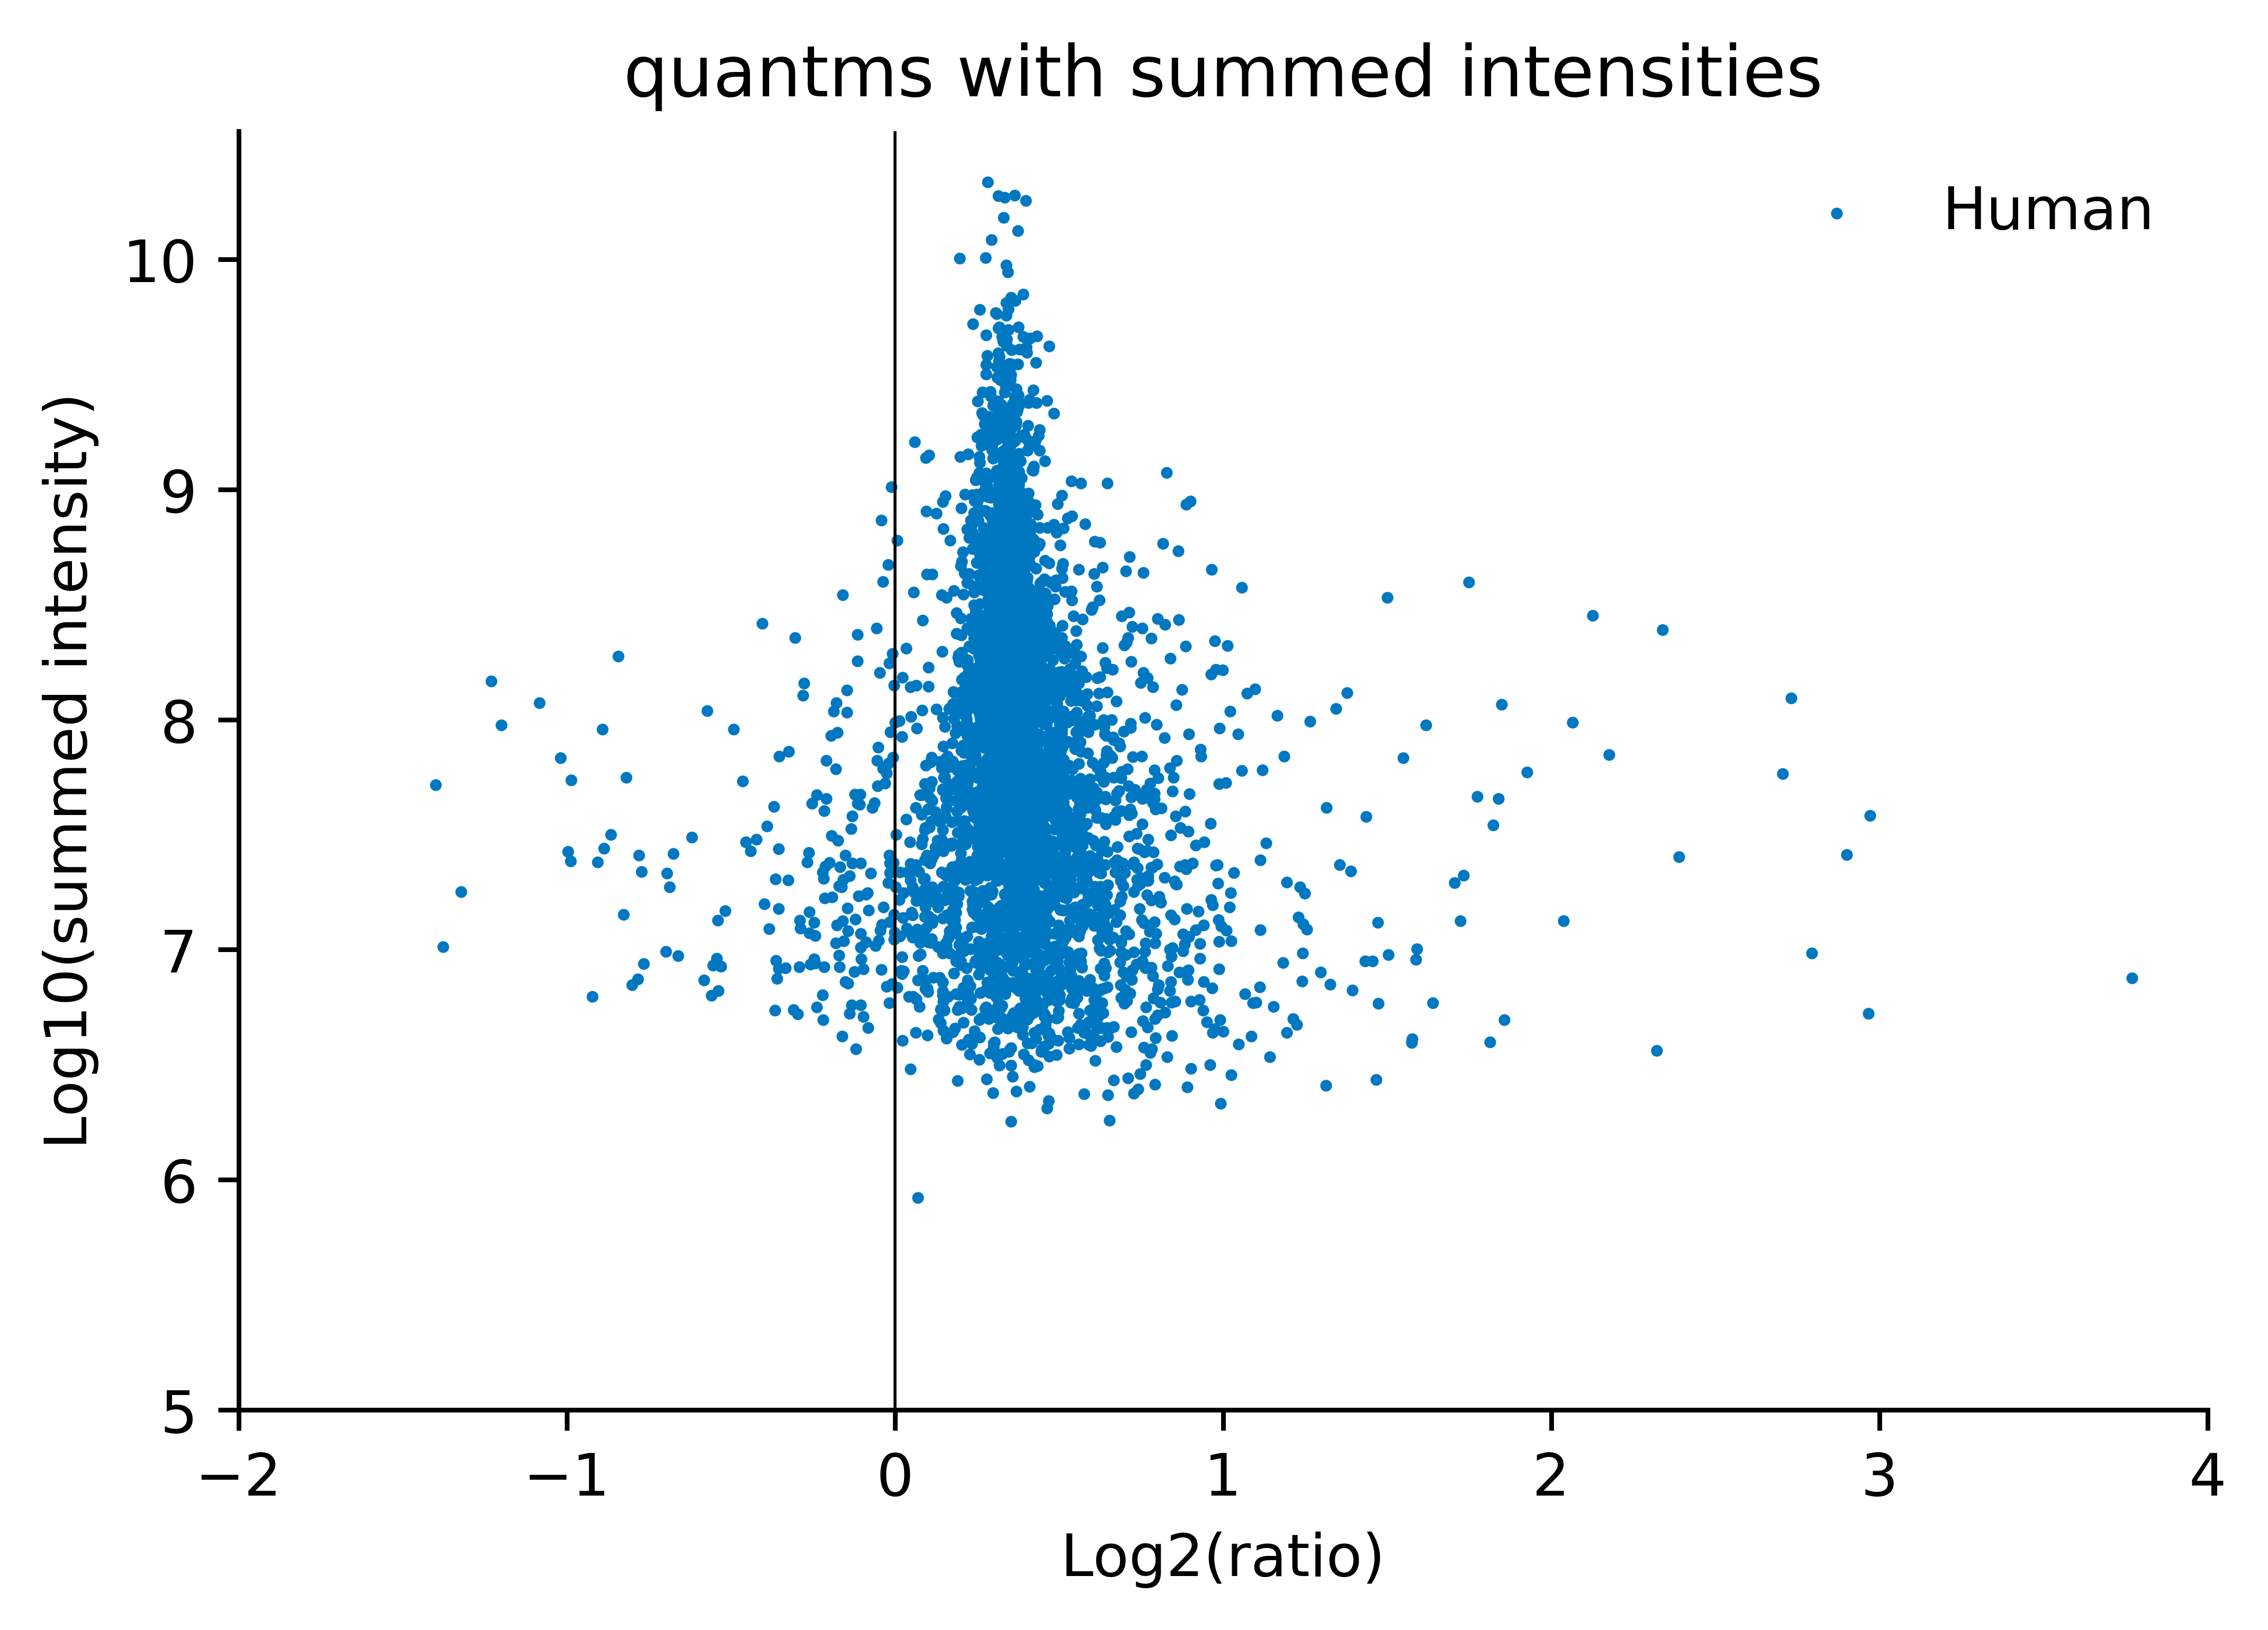

In [88]:
fig, ax = plt.subplots()

line1 = ax.scatter(quantmsMBR_HUMAN_pic["Log2(ratio)"], y=quantmsMBR_HUMAN_pic['Log10(summed intensity)'], c="#0078C1", s=1)


ax.axvline(x=0, c="black", linewidth=0.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend(handles=[line1], labels=['Human'], loc="best", frameon=False)

plt.title("quantms with summed intensities")
plt.xlim(-2,4)
plt.ylim(5)
plt.xlabel("Log2(ratio)")
plt.ylabel("Log10(summed intensity)")
plt.show()

0.38449835080299005
0.09290893857220112


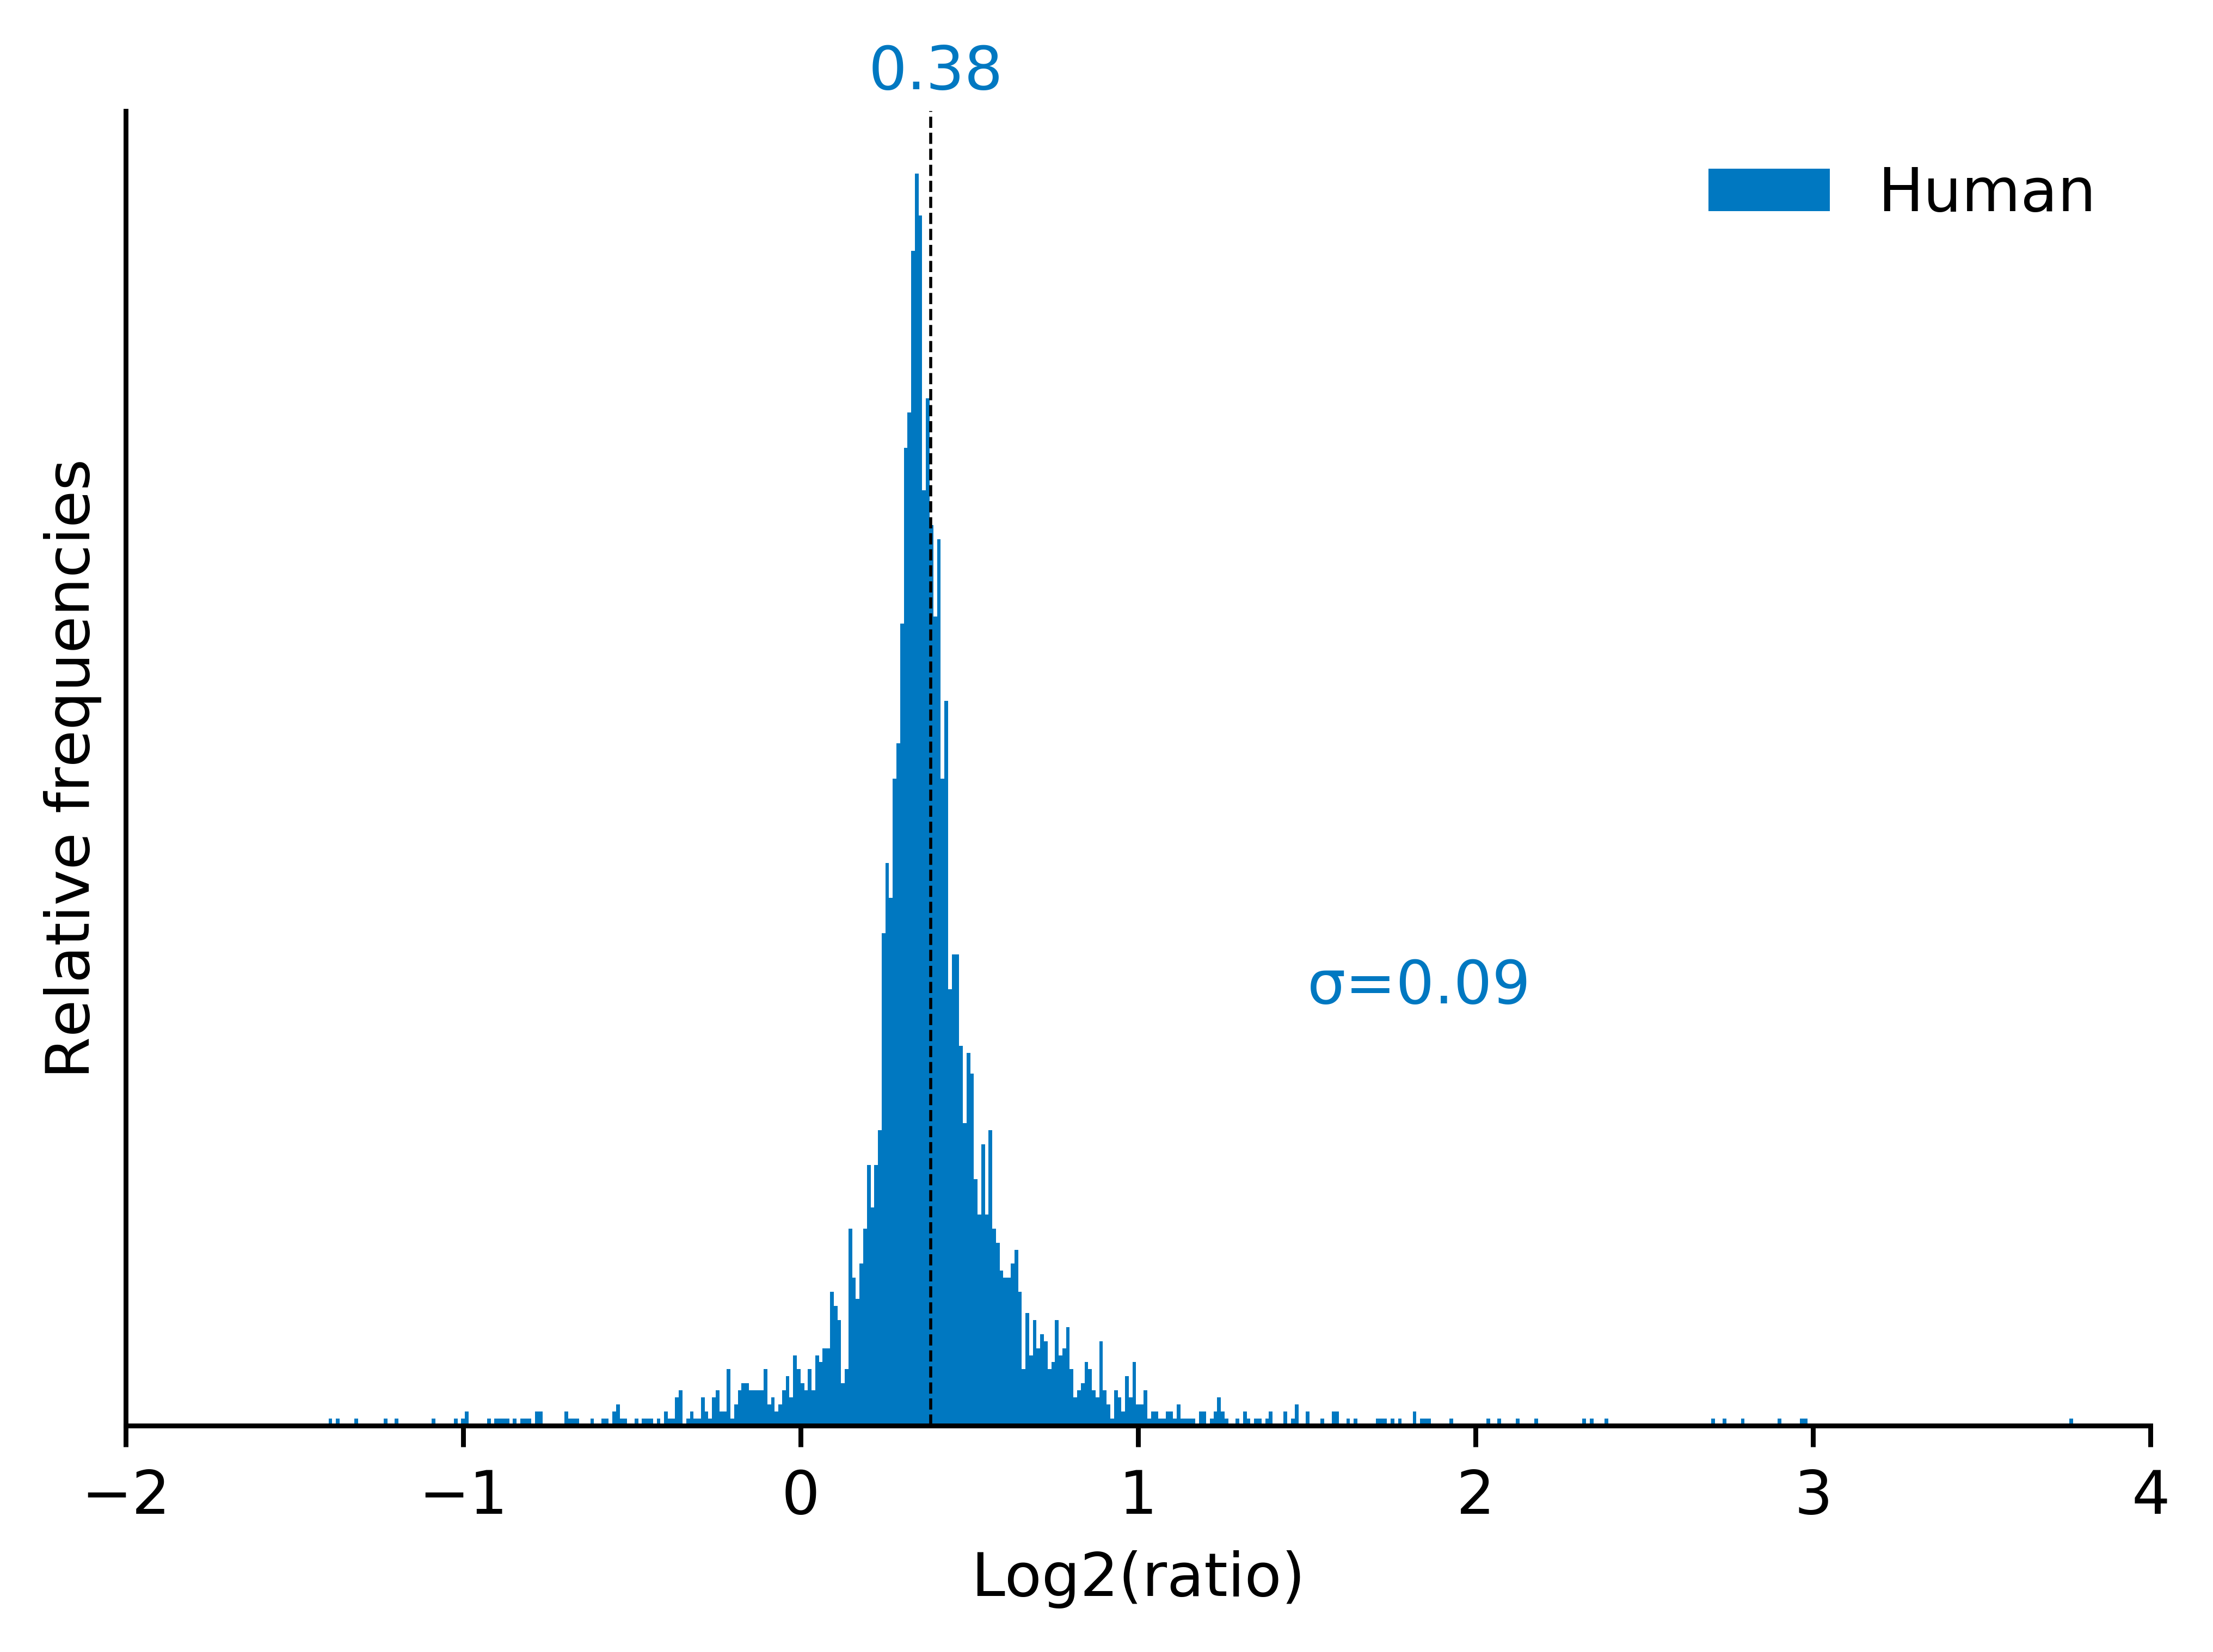

In [101]:
fig, ax = plt.subplots()

ax.hist(quantmsMBR_HUMAN_pic["Log2(ratio)"], bins=600, color="#0078C1")
u2 = np.mean(quantmsMBR_HUMAN_pic["Log2(ratio)"])
var2 = np.var(quantmsMBR_HUMAN_pic["Log2(ratio)"])
print(u2)
print(var2)


ax.legend(labels=['Human'], loc="best", frameon=False)

ax.axvline(x=0.38449835080299005, c="black", linewidth=0.5, ls="--")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.text(0.2,190,"0.38", color="#0078C1")

plt.text(1.5,60,"σ=0.09", color="#0078C1")

plt.yticks([])
plt.xlabel("Log2(ratio)")
plt.ylabel("Relative frequencies")
plt.xlim(-2,4)
plt.show()

In [9]:
import pandas as pd
MaxQuantMBR = pd.read_csv("./MaxQuantMBR/proteinGroups.txt", header=0, sep='\t')
MaxQuantMBR = MaxQuantMBR[(MaxQuantMBR['Reverse'] != "+") & (MaxQuantMBR['Potential contaminant'] != "+")]
MaxQuantMBR = MaxQuantMBR[-(MaxQuantMBR['Protein IDs'].str.contains("CON_") | (MaxQuantMBR['Protein IDs'].str.contains("REV_")))]
print(len(set(MaxQuantMBR['Protein IDs'])))
MaxQuantMBR.head()

4583


,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Potential contaminant,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions
75,sp|P0DPI2|GAL3A_HUMAN;sp|A0A0B4J2D5|GAL3B_HUMAN,sp|P0DPI2|GAL3A_HUMAN;sp|A0A0B4J2D5|GAL3B_HUMAN,7;7,7;7,7;7,sp|P0DPI2|GAL3A_HUMAN Glutamine amidotransfera...,2,7,7,7,...,NaN,75,7591;13100;14797;18614;28150;29394;39857,True;True;True;True;True;True;True,7743;13337;15062;18951;28732;29999;40672,272347;272348;272349;272350;272351;272352;2723...,175737;175738;175739;175740;175741;175742;1757...,175743;299109;337864;425635;646007;673476;914231,NaN,NaN
76,sp|A0AV96|RBM47_HUMAN,sp|A0AV96|RBM47_HUMAN,2,2,2,sp|A0AV96|RBM47_HUMAN RNA-binding protein 47 O...,1,2,2,2,...,NaN,76,31168;38790,True;True,31801;39588,1114132;1114133;1114134;1114135;1114136;111413...,710217;710218;710219;710220;710221;710222;8895...,710217;889518,NaN,NaN
77,sp|A0AVT1|UBA6_HUMAN,sp|A0AVT1|UBA6_HUMAN,30,30,30,sp|A0AVT1|UBA6_HUMAN Ubiquitin-like modifier-a...,1,30,30,30,...,NaN,77,2303;7194;8089;10557;11161;12291;13966;15432;1...,True;True;True;True;True;True;True;True;True;T...,2354;7341;8244;10748;11357;12511;14217;15706;1...,83036;83037;83038;83039;83040;83041;83042;8304...,54920;54921;54922;54923;54924;54925;54926;5492...,54938;167694;186734;240143;253661;278821;31932...,NaN,NaN
78,sp|A0FGR8|ESYT2_HUMAN,sp|A0FGR8|ESYT2_HUMAN,7,7,7,sp|A0FGR8|ESYT2_HUMAN Extended synaptotagmin-2...,1,7,7,7,...,NaN,78,496;1897;3002;17028;22474;28007;38855,True;True;True;True;True;True;True,503;1940;3069;17330;22880;28587;39654,17160;17161;17162;17163;17164;17165;17166;1716...,11702;11703;11704;11705;11706;11707;11708;1170...,11705;44871;71913;388196;514255;642606;891266,NaN,NaN
79,sp|A0JLT2|MED19_HUMAN,sp|A0JLT2|MED19_HUMAN,2,2,2,sp|A0JLT2|MED19_HUMAN Mediator of RNA polymera...,1,2,2,2,...,NaN,79,8718;24522,True;True,8879;24962,311342;311343;311344;311345;311346;311347;3113...,200505;200506;200507;200508;200509;200510;5608...,200507;560858,NaN,NaN


In [21]:
MaxQuantMBRPep = pd.read_csv("./MaxQuantMBR/peptides.txt", header=0, sep="\t")
MaxQuantMBRPep = MaxQuantMBRPep[(MaxQuantMBRPep['Reverse'] != "+") & (MaxQuantMBRPep['Potential contaminant'] != "+")]
MaxQuantMBRPepUnique = MaxQuantMBRPep[MaxQuantMBRPep['Unique (Groups)'] == 'yes']
print(len(set(MaxQuantMBRPepUnique['Sequence'])))
H = MaxQuantMBRPepUnique[['Sequence','Proteins','Experiment H1', 'Experiment H2', 'Experiment H3', 'Experiment H4', 'Experiment H5', 
                          'Experiment H6','Experiment H7', 'Experiment H8', 'Experiment H9', 'Experiment H10', 'Experiment H11', 
                          'Experiment H12','Experiment H13', 'Experiment H14', 'Experiment H15', 'Experiment H16', 'Experiment H17', 
                          'Experiment H18','Experiment H19', 'Experiment H20']]
H = H.dropna(how="all", axis=0, subset=['Experiment H1', 'Experiment H2', 'Experiment H3', 'Experiment H4', 'Experiment H5', 
                          'Experiment H6','Experiment H7', 'Experiment H8', 'Experiment H9', 'Experiment H10', 'Experiment H11', 
                          'Experiment H12','Experiment H13', 'Experiment H14', 'Experiment H15', 'Experiment H16', 'Experiment H17', 
                          'Experiment H18','Experiment H19', 'Experiment H20'])

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\IPython\core\interactiveshell.py:3296: DtypeWarning: Columns (164) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


40331


In [23]:
print(len(set(H[H['Proteins'].str.contains("HUMAN")]['Sequence'])))
print(len(set(H[H['Proteins'].str.contains("YEAST")]['Sequence'])))

36466


In [25]:
Y = MaxQuantMBRPepUnique[['Sequence','Proteins','Experiment Y1', 'Experiment Y2', 'Experiment Y3', 'Experiment Y4', 'Experiment Y5', 
                          'Experiment Y6','Experiment Y7', 'Experiment Y8', 'Experiment Y9', 'Experiment Y10', 'Experiment Y11', 
                          'Experiment Y12','Experiment Y13', 'Experiment Y14', 'Experiment Y15', 'Experiment Y16', 'Experiment Y17', 
                          'Experiment Y18','Experiment Y19', 'Experiment Y20']]
Y = Y.dropna(how="all", axis=0, subset=['Experiment Y2', 'Experiment Y3', 'Experiment Y4', 'Experiment Y5', 
                          'Experiment Y6','Experiment Y7', 'Experiment Y8', 'Experiment Y9', 'Experiment Y10', 'Experiment Y11', 
                          'Experiment Y12','Experiment Y13', 'Experiment Y14', 'Experiment Y15', 'Experiment Y16', 'Experiment Y17', 
                          'Experiment Y18','Experiment Y19', 'Experiment Y20'])


In [26]:
print(len(set(Y[Y['Proteins'].str.contains("HUMAN")]['Sequence'])))
print(len(set(Y[Y['Proteins'].str.contains("YEAST")]['Sequence'])))

36074
3390


### New MQ NoMBR

In [27]:
import pandas as pd
MaxQuantMBR = pd.read_csv("./MaxQuantNoMBR/proteinGroups.txt", header=0, sep='\t')
MaxQuantMBR = MaxQuantMBR[(MaxQuantMBR['Reverse'] != "+") & (MaxQuantMBR['Potential contaminant'] != "+")]
MaxQuantMBR = MaxQuantMBR[-(MaxQuantMBR['Protein IDs'].str.contains("CON_") | (MaxQuantMBR['Protein IDs'].str.contains("REV_")))]
print(len(set(MaxQuantMBR['Protein IDs'])))
MaxQuantMBR.head()

4634


C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\IPython\core\interactiveshell.py:3296: DtypeWarning: Columns (300,301,302) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Potential contaminant,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions
78,sp|P0DPI2|GAL3A_HUMAN;sp|A0A0B4J2D5|GAL3B_HUMAN,sp|P0DPI2|GAL3A_HUMAN;sp|A0A0B4J2D5|GAL3B_HUMAN,7;7,7;7,7;7,sp|P0DPI2|GAL3A_HUMAN Glutamine amidotransfera...,2,7,7,7,...,NaN,78,7961;13761;15534;19545;29689;30988;42068,True;True;True;True;True;True;True,8119;14009;15811;19897;30308;31631;42934,186801;186802;186803;186804;186805;186806;1868...,209312;209313;209314;209315;209316;209317;2093...,209320;356286;402056;509128;774935;807578;1097887,NaN,NaN
79,sp|A0AV96|RBM47_HUMAN,sp|A0AV96|RBM47_HUMAN,2,2,2,sp|A0AV96|RBM47_HUMAN RNA-binding protein 47 O...,1,2,2,2,...,NaN,79,32962;40963,True;True,33636;41812,764631;764632;764633;764634;764635;764636;7646...,854355;854356;854357;854358;854359;854360;8543...,854355;1068708,NaN,NaN
80,sp|A0AVT1|UBA6_HUMAN,sp|A0AVT1|UBA6_HUMAN,31,31,31,sp|A0AVT1|UBA6_HUMAN Ubiquitin-like modifier-a...,1,31,31,31,...,NaN,80,2413;5013;7546;8490;11093;11724;12908;14671;16...,True;True;True;True;True;True;True;True;True;T...,2466;5120;7699;8651;11292;11929;13139;14933;16...,58013;58014;58015;58016;58017;58018;58019;5802...,65195;65196;65197;65198;65199;65200;65201;6520...,65212;134547;199761;222613;286292;302046;33217...,NaN,NaN
81,sp|A0FGR8|ESYT2_HUMAN,sp|A0FGR8|ESYT2_HUMAN,7,7,7,sp|A0FGR8|ESYT2_HUMAN Extended synaptotagmin-2...,1,7,7,7,...,NaN,81,514;1979;3144;17876;23737;29538;41030,True;True;True;True;True;True;True,521;2024;3216;18192;24167;30154;41880,12037;12038;12039;12040;12041;12042;12043;1204...,13531;13532;13533;13534;13535;13536;13537;1353...,13535;53184;85548;464171;618863;770994;1070748,NaN,NaN
82,sp|A0JLT2|MED19_HUMAN,sp|A0JLT2|MED19_HUMAN,2,2,2,sp|A0JLT2|MED19_HUMAN Mediator of RNA polymera...,1,2,2,2,...,NaN,82,9153;25879,True;True,9320;26346,213374;213375;213376;213377;213378;213379;6028...,238939;238940;238941;238942;238943;238944;6738...,238941;673881,NaN,NaN


In [29]:
MaxQuantNoMBRPep = pd.read_csv("./MaxQuantNoMBR/peptides.txt", header=0, sep="\t")
MaxQuantNoMBRPep = MaxQuantNoMBRPep[(MaxQuantNoMBRPep['Reverse'] != "+") & (MaxQuantNoMBRPep['Potential contaminant'] != "+")]
MaxQuantNoMBRPepUnique = MaxQuantNoMBRPep[MaxQuantNoMBRPep['Unique (Groups)'] == 'yes']
print(len(set(MaxQuantNoMBRPepUnique['Sequence'])))
H = MaxQuantNoMBRPepUnique[['Sequence','Proteins','Experiment H1', 'Experiment H2', 'Experiment H3', 'Experiment H4', 'Experiment H5', 
                          'Experiment H6','Experiment H7', 'Experiment H8', 'Experiment H9', 'Experiment H10', 'Experiment H11', 
                          'Experiment H12','Experiment H13', 'Experiment H14', 'Experiment H15', 'Experiment H16', 'Experiment H17', 
                          'Experiment H18','Experiment H19', 'Experiment H20']]
H = H.dropna(how="all", axis=0, subset=['Experiment H1', 'Experiment H2', 'Experiment H3', 'Experiment H4', 'Experiment H5', 
                          'Experiment H6','Experiment H7', 'Experiment H8', 'Experiment H9', 'Experiment H10', 'Experiment H11', 
                          'Experiment H12','Experiment H13', 'Experiment H14', 'Experiment H15', 'Experiment H16', 'Experiment H17', 
                          'Experiment H18','Experiment H19', 'Experiment H20'])

42522


In [30]:
Y = MaxQuantNoMBRPepUnique[['Sequence','Proteins','Experiment Y1', 'Experiment Y2', 'Experiment Y3', 'Experiment Y4', 'Experiment Y5', 
                          'Experiment Y6','Experiment Y7', 'Experiment Y8', 'Experiment Y9', 'Experiment Y10', 'Experiment Y11', 
                          'Experiment Y12','Experiment Y13', 'Experiment Y14', 'Experiment Y15', 'Experiment Y16', 'Experiment Y17', 
                          'Experiment Y18','Experiment Y19', 'Experiment Y20']]
Y = Y.dropna(how="all", axis=0, subset=['Experiment Y2', 'Experiment Y3', 'Experiment Y4', 'Experiment Y5', 
                          'Experiment Y6','Experiment Y7', 'Experiment Y8', 'Experiment Y9', 'Experiment Y10', 'Experiment Y11', 
                          'Experiment Y12','Experiment Y13', 'Experiment Y14', 'Experiment Y15', 'Experiment Y16', 'Experiment Y17', 
                          'Experiment Y18','Experiment Y19', 'Experiment Y20'])
print(len(set(Y[Y['Proteins'].str.contains("HUMAN")]['Sequence'])))
print(len(set(Y[Y['Proteins'].str.contains("YEAST")]['Sequence'])))

35035
3538
